In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
class SimpleNN(nn.Module):
    def __init__(self, n_input, n_output):
        super(SimpleNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(n_input, 15),
            nn.LeakyReLU(),
            nn.Linear(15, 25),
            nn.LeakyReLU(),
            nn.Linear(25, 1)
        )
    
    def forward(self, x):
        return self.model(x)

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.normal_(m.weight)
        m.bias.data.fill_(0.01)

In [47]:
def sample_pnts1(num):
    pos_pnts = np.random.randint(10, 40, (num, 2))
    neg_pnts = np.random.randint(50, 100, (num, 2))
    pnts = np.concatenate((pos_pnts, neg_pnts), axis=0)
    labels = np.ones(num * 2)
    labels[num:] = 0
    return pnts, labels

def sample_pnts2(num):
    pos_pnts = np.random.randint(50, 80, (num, 2))
    neg_pnts = np.random.randint(0, 50, (num, 2))
    pnts = np.concatenate((pos_pnts, neg_pnts), axis=0)
    labels = np.ones(num * 2)
    labels[num:] = 0
    return pnts, labels

def sample_all_pnts():
    pnts = np.zeros((10000, 2))
    labels = np.zeros(10000)
    count = 0
    for i in range(100):
        for j in range(100):
            pnts[count, :] = np.asarray([i, j])
            if ((i >= 50) and (i <= 80)) and ((j >= 50) and (j <= 80)):
                labels[count] = 1
            if ((i >= 10) and (i <= 40)) and ((j >= 10) and (j <= 40)):
                labels[count] = 1
            count += 1
    return pnts, labels

In [134]:
def train_step(model, loss, optimizer, X_train, y_train):
    model.train()
    y_pred = model(X_train)
    l = F.binary_cross_entropy_with_logits(y_pred.squeeze(), y_train)
    optimizer.zero_grad()
    l.backward()
    nn.utils.clip_grad_norm_(model.parameters(), 0.1)
    optimizer.step()
    return l

def test(model, X_test):
    model.eval()
    y_pred = F.sigmoid(model(X_test))
    y_pred_logits = [1 if y > 0.5 else 0 for y in y_pred]
    return y_pred, y_pred_logits

# merge model
def merge(model1, model2, merged_model):
    state_dict = model1.state_dict()
    for key in state_dict:
        state_dict[key] = (state_dict[key] + model2.state_dict()[key]) / 2
    merged_model.load_state_dict(state_dict)

def fedlearn(center_model, models, optimizers, losses, datas):
    Loss = {i:[] for i in range(len(models))}
    for epoch in range(10000):
        for i in range(len(models)):
            l = train_step(models[i], losses[i], optimizers[i], datas[i][0], datas[i][1])
            Loss[i].append(l)
        merge(model1, model2, center_model)
        for model in models:
            model.load_state_dict(center_model.state_dict())
        if epoch % 250 == 0:
            print("epoch {:5} | loss1 {:5.3} | loss2 {:5.3}".format(epoch, Loss[0][-1], Loss[1][-1]))
    return Loss

def plot_density(model, X_test):
    probability, _ = test(model, X_test)
    data_dict = {
        'x': [],
        'y': [],
        'val': []
    }
    for i in range(X_test.shape[0]):
        data_dict['x'].append(X_test[i, 0])
        data_dict['y'].append(X_test[i, 1])
        data_dict['val'].append(probability[i].item())
    sns.scatterplot(data=data_dict, x='x', y='y', hue='val')

In [135]:
pnts1, labels1 = sample_pnts1(500)
pnts2, labels2 = sample_pnts2(500)
all_pnts, all_labels = sample_all_pnts()

X_train1, X_train2 = pnts1, pnts2
y_train1, y_train2 = labels1, labels2
shuffle_ind1 = np.arange(X_train1.shape[0])
shuffle_ind2 = np.arange(X_train2.shape[0])
np.random.shuffle(shuffle_ind1)
np.random.shuffle(shuffle_ind2)

X_train1 = X_train1[shuffle_ind1]
y_train1 = y_train1[shuffle_ind1]
X_train2 = X_train2[shuffle_ind2]
y_train2 = y_train2[shuffle_ind2]
X_train1 = (X_train1 - 50) / 50
X_train2 = (X_train2 - 50) / 50

X_train_torch1 = torch.FloatTensor(X_train1)
X_train_torch2 = torch.FloatTensor(X_train2)
X_train_all_torch = torch.FloatTensor(all_pnts)
X_train_all_torch = (X_train_all_torch - 50) / 50

y_train_torch1 = torch.FloatTensor(y_train1)
y_train_torch2 = torch.FloatTensor(y_train2)
y_train_all_torch = torch.FloatTensor(all_labels)

In [136]:
model1 = SimpleNN(2, 1)
model2 = SimpleNN(2, 1)
model3 = SimpleNN(2, 1)
# model.apply(init_weights)
optimizer1 = optim.Adam(model1.parameters(), lr=0.001)
optimizer2 = optim.Adam(model2.parameters(), lr=0.001)
# optimizer3 = optim.Adam(model3.parameters(), lr=0.0001)
loss1 = nn.BCEWithLogitsLoss()
loss2 = nn.BCEWithLogitsLoss()

In [137]:
models = [model1, model2]
optimizers = [optimizer1, optimizer2]
losses = [loss1, loss2]
datas = [(X_train_torch1, y_train_torch1), (X_train_torch2, y_train_torch2)]
Loss = fedlearn(model3, models, optimizers, losses, datas)

epoch     0 | loss1 0.707 | loss2 0.666
epoch   250 | loss1 0.697 | loss2 0.688
epoch   500 | loss1 0.692 | loss2  0.69
epoch   750 | loss1 0.693 | loss2 0.687
epoch  1000 | loss1 0.698 | loss2  0.68
epoch  1250 | loss1   0.7 | loss2 0.675
epoch  1500 | loss1 0.704 | loss2 0.668
epoch  1750 | loss1 0.706 | loss2 0.662
epoch  2000 | loss1 0.701 | loss2 0.655
epoch  2250 | loss1 0.706 | loss2 0.636
epoch  2500 | loss1 0.723 | loss2 0.613
epoch  2750 | loss1 0.742 | loss2 0.593
epoch  3000 | loss1 0.758 | loss2 0.575
epoch  3250 | loss1 0.772 | loss2  0.56
epoch  3500 | loss1 0.783 | loss2 0.549
epoch  3750 | loss1 0.793 | loss2 0.538
epoch  4000 | loss1 0.801 | loss2  0.53
epoch  4250 | loss1  0.81 | loss2 0.522
epoch  4500 | loss1  0.83 | loss2  0.51
epoch  4750 | loss1 0.847 | loss2 0.496
epoch  5000 | loss1 0.858 | loss2 0.488
epoch  5250 | loss1 0.863 | loss2 0.483
epoch  5500 | loss1 0.865 | loss2 0.479
epoch  5750 | loss1 0.865 | loss2 0.476
epoch  6000 | loss1 0.865 | loss2 0.474


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


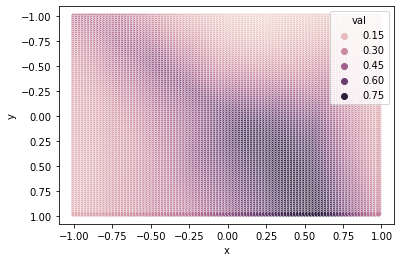

In [138]:
plot_density(model1, X_train_all_torch)